In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
from collections import OrderedDict
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torchvision
from torchvision import transforms,models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [13]:
train_dir = '/kaggle/input/covid-dataset/data/train'
test_dir =  '/kaggle/input/covid-dataset/data/test'

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.GaussianBlur(1, sigma=(0.1, 0.5)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(train_dir, transform= transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True)

dataset = torchvision.datasets.ImageFolder(test_dir, transform= transform)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True)


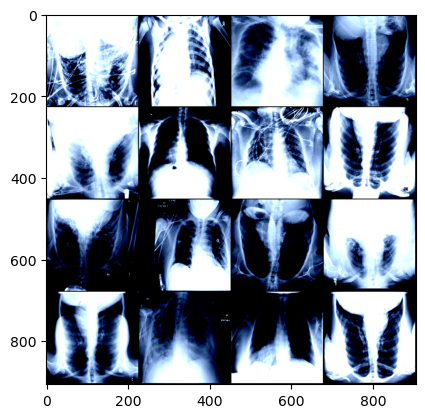

In [14]:
def imshow(image_torch):
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(image_torch)

X_train, y_train = next(iter(train_loader))

# Make a grid from batch
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4)

imshow(image_grid)

In [15]:
model = models.vgg19(pretrained = True)


In [16]:
for params in model.parameters():
    params.requires_grad = False

In [17]:
model.classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(25088,1)),
    ('Output',nn.Sigmoid())
]))
model = model.to(device)


In [20]:
opt = optim.Adam(model.classifier.parameters())
loss_function = nn.BCELoss()
train_losses=[]

model.train()
NUM_EPOCHS = 30
for epoch in range(NUM_EPOCHS):
    train_loss= 0
    test_loss= 0
    for i,(img,label) in enumerate(train_loader):
        img = img.to(device)
        label = label.to(device)
        # zero the gradients
        opt.zero_grad()

        # forward pass
        output = model(img)

        # calc losses
        loss = loss_function(output.squeeze(),label.float())

        # propagate losses
        loss.backward()

        # update weights
        opt.step()
        if i % 100 == 0:
            print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Step {i+1}/{len(train_loader)},'
                  f'Loss: {loss.item():.4f}')

        # update current train loss
        train_loss += loss.item()


    train_losses.append(train_loss)
    print(f"epoch: {epoch+1}, train_loss: {train_loss}")


Epoch 1/30, Step 1/899,Loss: 0.7165
Epoch 1/30, Step 101/899,Loss: 0.2415
Epoch 1/30, Step 201/899,Loss: 0.3018
Epoch 1/30, Step 301/899,Loss: 0.1709
Epoch 1/30, Step 401/899,Loss: 0.1655
Epoch 1/30, Step 501/899,Loss: 0.0772
Epoch 1/30, Step 601/899,Loss: 0.1025
Epoch 1/30, Step 701/899,Loss: 0.1912
Epoch 1/30, Step 801/899,Loss: 0.2046
epoch: 1, train_loss: 166.04919734643772
Epoch 2/30, Step 1/899,Loss: 0.3179
Epoch 2/30, Step 101/899,Loss: 0.0853
Epoch 2/30, Step 201/899,Loss: 0.1511
Epoch 2/30, Step 301/899,Loss: 0.0562
Epoch 2/30, Step 401/899,Loss: 0.2327
Epoch 2/30, Step 501/899,Loss: 0.1749
Epoch 2/30, Step 601/899,Loss: 0.1614
Epoch 2/30, Step 701/899,Loss: 0.0439
Epoch 2/30, Step 801/899,Loss: 0.1150
epoch: 2, train_loss: 108.74317190726288
Epoch 3/30, Step 1/899,Loss: 0.1295
Epoch 3/30, Step 101/899,Loss: 0.0173
Epoch 3/30, Step 201/899,Loss: 0.0822
Epoch 3/30, Step 301/899,Loss: 0.3127
Epoch 3/30, Step 401/899,Loss: 0.0360
Epoch 3/30, Step 501/899,Loss: 0.1870
Epoch 3/30, 

<Axes: >

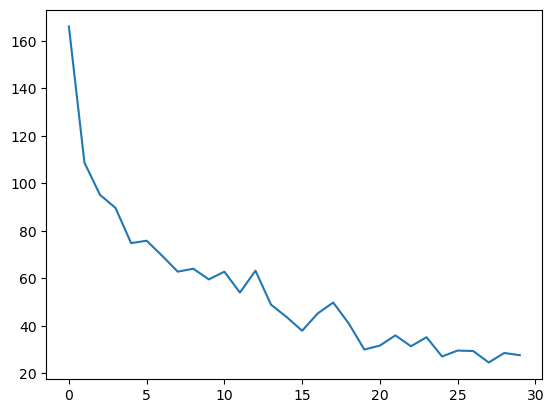

In [21]:
sns.lineplot(x = range(len(train_losses)), y = train_losses)


In [22]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader, 0):
    inputs, y_test_temp = data
    inputs = inputs.to(device)
    y_test_temp = y_test_temp.to(device)
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()


    y_test.extend(y_test_temp.cpu().numpy())
    y_pred.extend(y_test_hat_temp.cpu().numpy())

In [24]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {np.round(acc * 100, 2)} %")

Accuracy Score: 84.8 %


In [31]:
PATH = '/kaggle/working/model_state_dict.pth'
torch.save(model.state_dict(), PATH)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])

batch_size = 64
trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/covid-dataset/data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.ImageFolder(root='/kaggle/input/covid-dataset/data/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ['COVID', 'NON-COVID']

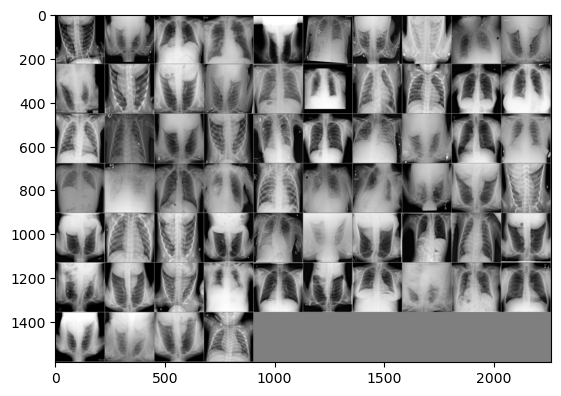

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images, nrow=10))

In [4]:
class ImageClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1,64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(43264, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)/2
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)/2
        x = self.fc3(x)
        x = self.relu(x)
        x = self.sigmoid(x)
        return x

In [5]:
model = ImageClassificationNet().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)


In [6]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Step {i+1}/{len(trainloader)},'
                  f'Loss: {loss.item():.4f}')

Epoch 1/10, Step 1/450,Loss: 0.6930
Epoch 1/10, Step 101/450,Loss: 0.6675
Epoch 1/10, Step 201/450,Loss: 0.6488
Epoch 1/10, Step 301/450,Loss: 0.5863
Epoch 1/10, Step 401/450,Loss: 0.6274
Epoch 2/10, Step 1/450,Loss: 0.6140
Epoch 2/10, Step 101/450,Loss: 0.5713
Epoch 2/10, Step 201/450,Loss: 0.5699
Epoch 2/10, Step 301/450,Loss: 0.6351
Epoch 2/10, Step 401/450,Loss: 0.5949
Epoch 3/10, Step 1/450,Loss: 0.6241
Epoch 3/10, Step 101/450,Loss: 0.5774
Epoch 3/10, Step 201/450,Loss: 0.5512
Epoch 3/10, Step 301/450,Loss: 0.6258
Epoch 3/10, Step 401/450,Loss: 0.5181
Epoch 4/10, Step 1/450,Loss: 0.4927
Epoch 4/10, Step 101/450,Loss: 0.4862
Epoch 4/10, Step 201/450,Loss: 0.6774
Epoch 4/10, Step 301/450,Loss: 0.6678
Epoch 4/10, Step 401/450,Loss: 0.4344
Epoch 5/10, Step 1/450,Loss: 0.5681
Epoch 5/10, Step 101/450,Loss: 0.5694
Epoch 5/10, Step 201/450,Loss: 0.5328
Epoch 5/10, Step 301/450,Loss: 0.6643
Epoch 5/10, Step 401/450,Loss: 0.4919
Epoch 6/10, Step 1/450,Loss: 0.5472
Epoch 6/10, Step 101/450

In [7]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    inputs = inputs.to(device)
    y_test_temp = y_test_temp.to(device)
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()


    y_test.extend(y_test_temp.cpu().numpy())
    y_test_hat.extend(y_test_hat_temp.cpu().numpy())

In [8]:
acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')

Accuracy: 60.11 %


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [45]:
import os
main_dir = "/kaggle/input/covid/archive/Covid19-dataset"
#set the path to the train dir
train_dir = os.path.join(main_dir, 'train')
#set the path to the test dir
test_dir = os.path.join(main_dir, 'test')

#directory with the training covid images
train_covid_dir = os.path.join(train_dir, 'covid')
#directory with the training normal images
train_normal_dir = os.path.join(train_dir, 'non-covid')
#directory with the testing covid images
test_covid_dir = os.path.join(test_dir, 'covid')
#directory with the testing normal images
test_normal_dir = os.path.join(test_dir, 'non-covid')

In [46]:
#print the filenames
train_covid_names = os.listdir(train_covid_dir)
print(train_covid_names[:10])

train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

test_covid_names = os.listdir(test_covid_dir)
print(test_covid_names[:10])

test_normal_names = os.listdir(test_normal_dir)
print(train_normal_names[:10])

['032.jpeg', '01.jpeg', 'COVID-00014.jpg', '080.jpg', '060.jpeg', '092.png', 'COVID-00005.jpg', 'COVID-00031.jpg', '059.jpeg', '067.jpg']
['071.jpeg', '014.jpeg', '073.jpeg', '05.jpeg', '023.jpeg', '01.jpeg', '096.jpeg', '060.jpeg', '063.jpeg', '059.jpeg']
['0108.jpeg', '0119.jpeg', '0115.jpeg', 'auntminnie-2020_01_31_20_24_2322_2020_01_31_x-ray_coronavirus_US.jpg', 'COVID-00037.jpg', '0106.jpeg', '0111.jpg', 'COVID-00022.jpg', 'auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '0120.jpg']
['071.jpeg', '014.jpeg', '073.jpeg', '05.jpeg', '023.jpeg', '01.jpeg', '096.jpeg', '060.jpeg', '063.jpeg', '059.jpeg']


In [47]:
#print the total no of images present in each dir
print("Training set: ", len(train_covid_names + train_normal_names))
print("Testing set: ", len(test_covid_names + test_normal_names))

Training set:  181
Testing set:  46


['/kaggle/input/covid/archive/Covid19-dataset/train/covid/032.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/01.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/COVID-00014.jpg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/080.jpg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/060.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/092.png', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/COVID-00005.jpg', '/kaggle/input/covid/archive/Covid19-dataset/train/covid/COVID-00031.jpg']
['/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/071.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/014.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/073.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/05.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/023.jpeg', '/kaggle/input/covid/archive/Covid19-dataset/train/non-covid/01.jpeg', '/kagg

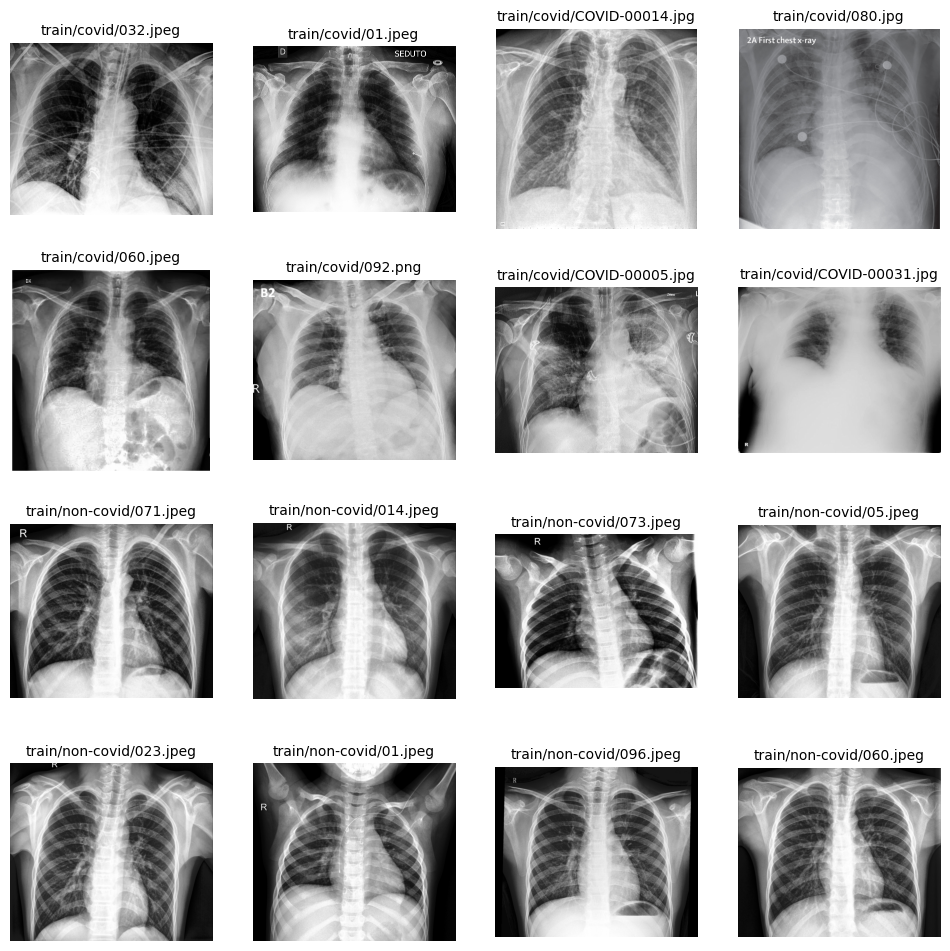

In [48]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 4
#set the figure size
fig = plt.gcf()
fig.set_size_inches(12,12)
#get the filenames from the covid & normal dir of the train dataset
covid_pic = [os.path.join(train_covid_dir, filename) for filename in train_covid_names[0:8]]
normal_pic = [os.path.join(train_normal_dir, filename) for filename in train_normal_names[0:8]]
#print the list
print(covid_pic)
print(normal_pic)
#merge the covid and normal list
merged_list = covid_pic+normal_pic

for i, img_path in enumerate(merged_list):
  data = img_path.split('/',6)[6]
  sp = plt.subplot(rows, cols, i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=10)
  plt.imshow(img, cmap='gray')
plt.show()

In [49]:
# generate training,testing and validation batches
img_width = 224
img_height = 224
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.3,
                                zoom_range = 0.2,
                                shear_range = 0.2,
                                vertical_flip = True,
                                horizontal_flip = True)
dgen_validation = ImageDataGenerator(rescale=1./255)
dgen_test = ImageDataGenerator(rescale=1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=(img_width,img_height),
                                                 subset = 'validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir,
                                                 target_size=(img_width,img_height),
                                                 batch_size = 32,
                                                 class_mode = 'binary')



Found 127 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [50]:
#get the class indices
train_generator.class_indices

{'covid': 0, 'non-covid': 1}

In [51]:
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf
l1_factor = 0.01
l2_factor = 0.01
model = Sequential()
# add the convolutional layer
# filters, size of filters,padding,activation_function,input_shape
model.add(Conv2D(64, (3,3), padding='SAME', activation='relu', input_shape=(img_width,img_height,3)))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# place a dropout layer
#model.add(Dropout(0.2))
# add another convolutional layer
model.add(Conv2D(64, (3,3), padding='SAME', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# place a dropout layer
#model.add(Dropout(0.5))
# add another convolutional layer
model.add(Conv2D(64, (3,3), padding='SAME', activation='relu'))
# pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
# Flatten layer
model.add(Flatten())
# add a dense layer : amount of nodes, activation
model.add(Dense(512, activation='relu'))
# add a dense layer : amount of nodes, activation
model.add(Dense(256, activation='relu'))
# place a dropout layer
# 0.5 drop out rate is recommended, half input nodes will be dropped at each update
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [52]:
#compile the model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='/kaggle/working/covid_classification.h5', save_best_only=True)

callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
#train the model
history = model.fit(train_generator,
                    epochs=50,
                    validation_data = validation_generator, callbacks = [callback])

Epoch 1/50
4/4 [==============================] - 21s 5s/step - loss: 1.6307 - accuracy: 0.4803 - val_loss: 0.6702 - val_accuracy: 0.6111
Epoch 2/50
4/4 [==============================] - 19s 5s/step - loss: 0.6983 - accuracy: 0.5118 - val_loss: 0.6840 - val_accuracy: 0.6111
Epoch 3/50
4/4 [==============================] - 17s 4s/step - loss: 0.6888 - accuracy: 0.5748 - val_loss: 0.6688 - val_accuracy: 0.6852
Epoch 4/50
4/4 [==============================] - 17s 4s/step - loss: 0.6504 - accuracy: 0.6220 - val_loss: 0.6294 - val_accuracy: 0.6111
Epoch 5/50
4/4 [==============================] - 18s 4s/step - loss: 0.6505 - accuracy: 0.6378 - val_loss: 0.6380 - val_accuracy: 0.6852
Epoch 6/50
4/4 [==============================] - 17s 4s/step - loss: 0.5208 - accuracy: 0.7874 - val_loss: 0.6016 - val_accuracy: 0.6481
Epoch 7/50
4/4 [==============================] - 18s 4s/step - loss: 0.5473 - accuracy: 0.7244 - val_loss: 0.4810 - val_accuracy: 0.7778
Epoch 8/50
4/4 [==================

In [54]:
#get the keys of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

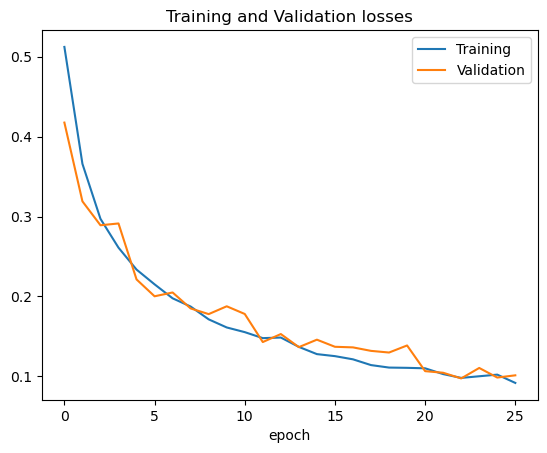

In [14]:
#plot graph between training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

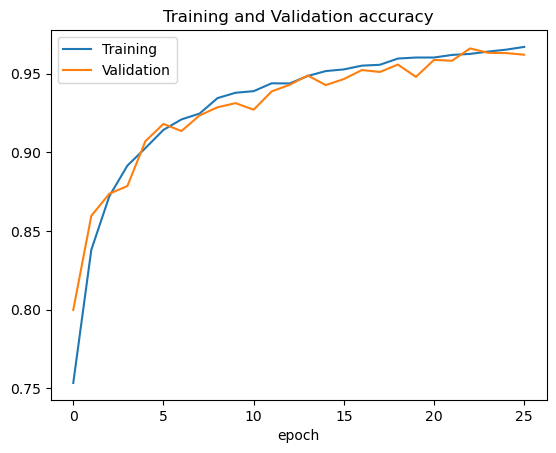

In [15]:
#plot graph between training and validation accuarcy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')

In [16]:
#PATH = '/kaggle/working/covid_classification_model_weights.h5'
#model.save_weights(PATH)

In [55]:
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the model
#model = load_model('/kaggle/working/covid_classification.h5')

# Make predictions on the test data
y_pred = model.predict(test_generator)

2/2 [==============================] - 2s 309ms/step


<Axes: >

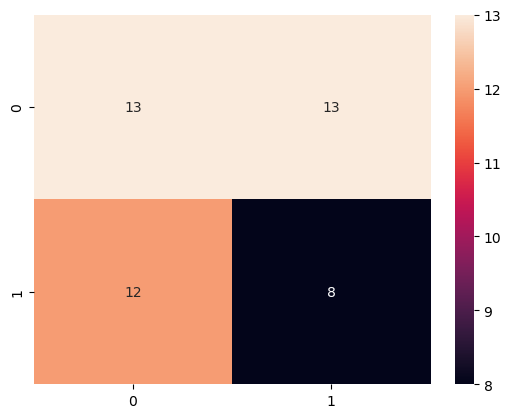

In [56]:
# Convert the predictions to binary labels
y_pred = (y_pred > 0.5).astype(int)

# Get the true labels of the test data
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap to display the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

In [57]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.52      0.50      0.51        26
           1       0.38      0.40      0.39        20

    accuracy                           0.46        46
   macro avg       0.45      0.45      0.45        46
weighted avg       0.46      0.46      0.46        46



In [58]:
# get the test acuarcy and loss
test_loss , test_acc = model.evaluate(test_generator)

print('test loss :{} test acc :{}'.format(test_loss, test_acc))

2/2 [==============================] - 2s 304ms/step - loss: 0.0513 - accuracy: 0.9783
test loss :0.05129736289381981 test acc :0.97826087474823


In [64]:
from tensorflow.keras.utils import load_img, img_to_array

img_path ='/kaggle/input/covid-dataset/data/test/non-covid/Normal (11305).png'
img = load_img(img_path, target_size=(224,224))
images = img_to_array(img)
images = np.expand_dims(images, axis=0)
prediction = model.predict(images)
#print(filename)

if prediction == 0:
    print('COVID Detected')
else:
    print('COVID Not Detected')

1/1 [==============================] - 0s 54ms/step
COVID Not Detected


In [65]:
PATH = '/kaggle/working/covid_classification_model_weights_new.hdf5'
model.save_weights(PATH)